In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [5]:
print(torchvisio.__version__)

NameError: name 'torchvision' is not defined

In [2]:
PATH='drive/MyDrive/Subjectivity'

In [13]:
import os

class CharacterDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.labels = self.data.iloc[:, 0].values
        self.images = self.data.iloc[:, 1:].values.reshape(-1, 28, 28).astype('float32')
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
# Load the dataset
csv_file = os.path.join(PATH, 'data', 'characters.csv')
dataset = CharacterDataset(csv_file, transform=transform)

# Create DataLoader
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Example of iterating through the DataLoader
for images, labels in dataloader:
    print(images.shape, labels.shape)
    break

torch.Size([64, 1, 224, 224]) torch.Size([64])


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Load the mapping from mapping.txt
def load_mapping(mapping_file):
    mapping = {}
    with open(mapping_file, 'r') as f:
        for line in f:
            key, value = line.strip().split()
            mapping[int(key)] = chr(int(value))
    return mapping

In [7]:
mapping_file = os.path.join(PATH, 'data', 'mapping.txt')
mapping = load_mapping(mapping_file)

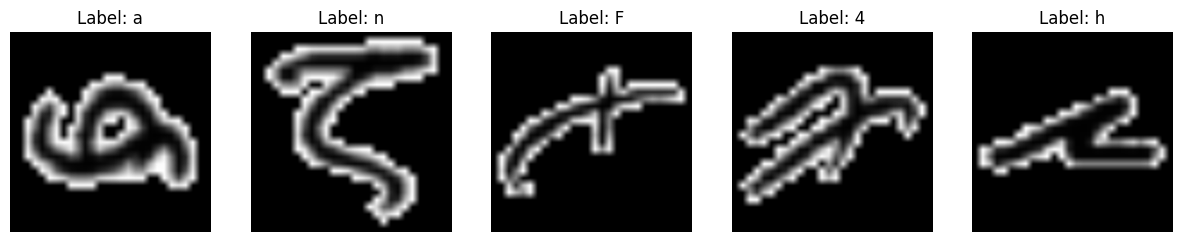

In [14]:
import matplotlib.pyplot as plt
# Display the first few images along with their ASCII labels
def show_images(dataset, mapping, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        image, label = dataset[i]
        image = image.numpy().squeeze()
        ascii_label = mapping[label]
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f'Label: {ascii_label}')
        axes[i].axis('off')
    plt.show()

show_images(dataset, mapping=mapping, num_images=5)

In [15]:

# Load a pretrained model (e.g., resnet18 pretrained on ImageNet)
model = models.resnet18(pretrained=True)

# Modify the model to fit our dataset
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(mapping))

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 206MB/s]


In [16]:
device

device(type='cuda', index=0)

In [18]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

In [17]:

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader)}')


Epoch [1/10], Loss: 0.4293062466910395


KeyboardInterrupt: 

In [ ]:
PATH = './resnet_.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
model = Net()
net.load_state_dict(torch.load(PATH))

In [ ]:

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total}%')